# Data Augmentation

In this notebook is shown how to generate new data for feeding the model rotating the data already available.

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [3]:
import os
#import cv2
import tensorflow.keras
# from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [4]:
# Muestro la version de keras
tensorflow.keras.__version__

'2.3.0-tf'

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [6]:
get_available_gpus()

['/device:GPU:0']

In [7]:
#import tensorflow as tf
#tf.test.is_gpu_available() Deprecated
#tf.config.list_physical_devices('GPU')

In [8]:
#tf.config.experimental.list_physical_devices('GPU')

In [9]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
#ff = glob.glob('./ground3T/*')
ff = glob.glob('../IXI-T1/*')

In [14]:
ff[0]

'../IXI-T1\\IXI002-Guys-0828-T1.nii.gz'

In [15]:
len(ff)

581

In [19]:
# Load the filenames in path
individuals = glob.glob('../IXI-T1/*.nii.gz')

In [20]:
from urllib.request import urlretrieve
import os

import itk
import SimpleITK as sitk
from itkwidgets import view

In [21]:
individuals[0]

'../IXI-T1\\IXI002-Guys-0828-T1.nii.gz'

In [22]:
image = itk.imread(individuals[0])
view(image, rotate=False)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageSS3; proxy …

In [23]:
#print(image.GetSize())
print("Origin:" , image.GetOrigin())
print(image.GetSpacing())
print(image.GetDirection())
print(image.GetNumberOfComponentsPerPixel())

Origin: itkPointD3 ([88.6399, -116.532, -112.114])
itkVectorD3 ([0.9375, 0.9375, 1.2])
<itkMatrixPython.itkMatrixD33; proxy of <Swig Object of type 'itkMatrixD33 *' at 0x0000028C8F5934E0> >
1


In [24]:
# Reference:
# https://stackoverflow.com/questions/56171643/simpleitk-rotation-of-mri-image
# https://github.com/rock-learning/pytransform3d/blob/7589e083a50597a75b12d745ebacaa7cc056cfbd/pytransform3d/rotations.py#L302

def matrix_from_axis_angle(a):
    """ Compute rotation matrix from axis-angle.
    This is called exponential map or Rodrigues' formula.
    Parameters
    ----------
    a : array-like, shape (4,)
        Axis of rotation and rotation angle: (x, y, z, angle)
    Returns
    -------
    R : array-like, shape (3, 3)
        Rotation matrix
    """
    ux, uy, uz, theta = a
    c = np.cos(theta)
    s = np.sin(theta)
    ci = 1.0 - c
    R = np.array([[ci * ux * ux + c,
                   ci * ux * uy - uz * s,
                   ci * ux * uz + uy * s],
                  [ci * uy * ux + uz * s,
                   ci * uy * uy + c,
                   ci * uy * uz - ux * s],
                  [ci * uz * ux - uy * s,
                   ci * uz * uy + ux * s,
                   ci * uz * uz + c],
                  ])

    # This is equivalent to
    # R = (np.eye(3) * np.cos(theta) +
    #      (1.0 - np.cos(theta)) * a[:3, np.newaxis].dot(a[np.newaxis, :3]) +
    #      cross_product_matrix(a[:3]) * np.sin(theta))

    return R


def resample(image, transform):
    """
    This function resamples (updates) an image using a specified transform
    :param image: The sitk image we are trying to transform
    :param transform: An sitk transform (ex. resizing, rotation, etc.
    :return: The transformed sitk image
    """
    reference_image = image
    interpolator = sitk.sitkLinear
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)


def get_center(img):
    """
    This function returns the physical center point of a 3d sitk image
    :param img: The sitk image we are trying to find the center of
    :return: The physical center point of the image
    """
    width, height, depth = img.GetSize()
    return img.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                              int(np.ceil(height/2)),
                                              int(np.ceil(depth/2))))


def rotation3d(image, theta_x, theta_y, theta_z, show=False):
    """
    This function rotates an image across each of the x, y, z axes by theta_x, theta_y, and theta_z degrees
    respectively
    :param image: An sitk MRI image
    :param theta_x: The amount of degrees the user wants the image rotated around the x axis
    :param theta_y: The amount of degrees the user wants the image rotated around the y axis
    :param theta_z: The amount of degrees the user wants the image rotated around the z axis
    :param show: Boolean, whether or not the user wants to see the result of the rotation
    :return: The rotated image
    """
    theta_x = np.deg2rad(theta_x)
    theta_y = np.deg2rad(theta_y)
    theta_z = np.deg2rad(theta_z)
    euler_transform = sitk.Euler3DTransform()
    #print(euler_transform.GetMatrix())
    image_center = get_center(image)
    euler_transform.SetCenter(image_center)

    direction = image.GetDirection()
    axis_angle_x = (direction[0], direction[3], direction[6], theta_x)
    axis_angle_y = (direction[1], direction[4], direction[7], theta_y)
    axis_angle_z = (direction[2], direction[5], direction[8], theta_z)
    np_rot_mat_x = matrix_from_axis_angle(axis_angle_x)
    np_rot_mat_y = matrix_from_axis_angle(axis_angle_y)
    np_rot_mat_z = matrix_from_axis_angle(axis_angle_z)
    euler_transform.SetMatrix(np_rot_mat_x.dot(np_rot_mat_y).dot(np_rot_mat_z).flatten().tolist())
    resampled_image = resample(image, euler_transform)
    if show:
        slice_num = int(input("Enter the index of the slice you would like to see"))
        plt.imshow(sitk.GetArrayFromImage(resampled_image)[slice_num])
        plt.show()
    return resampled_image

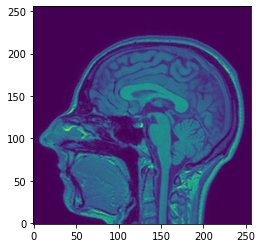

In [25]:
img = sitk.ReadImage(individuals[0])
img_arr = sitk.GetArrayFromImage(img)[75] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin="lower")
plt.show()

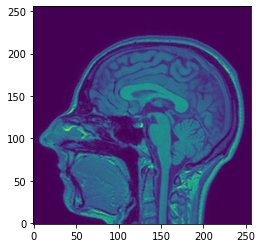

In [26]:
img_arr = sitk.GetArrayFromImage(img)[75,:,:] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower')
plt.show()

In [31]:
# Show the image in Fiji
%env SITK_SHOW_COMMAND='C:\Portable\Fiji.app\ImageJ-win64.exe'
sitk.Show(img)

env: SITK_SHOW_COMMAND='C:\Portable\Fiji.app\ImageJ-win64.exe'


In [29]:
# Show the image in Slicer
%env SITK_SHOW_COMMAND='C:\Program Files\Slicer 4.10.2\Slicer.exe'
sitk.Show(img)

env: SITK_SHOW_COMMAND='C:\Program Files\Slicer 4.10.2\Slicer.exe'


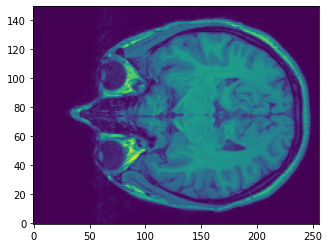

In [27]:
img_arr = sitk.GetArrayFromImage(img)[:,128,:] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower', aspect=1.3)
plt.show()

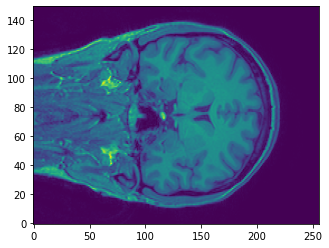

In [30]:
img_arr = sitk.GetArrayFromImage(img)[:,:,128] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower', aspect=1.3)
plt.show()

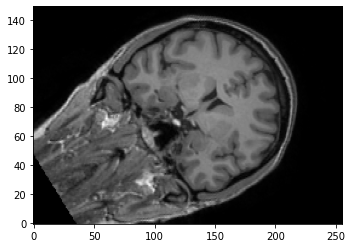

In [35]:
img_rotx_30 = rotation3d(img, 30, 0, 0)
img_arr = sitk.GetArrayFromImage(img_rotx_30)[:,:,128] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower', cmap='gray', aspect=1.2)
plt.show()


In [55]:
sitk.Show(img_rotx_30)

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


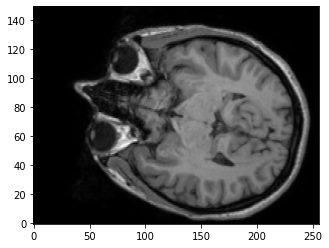

In [64]:
img_roty_15 = rotation3d(img, 0, 15, 0)
img_arr = sitk.GetArrayFromImage(img_roty_15)[:,128,:] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower', cmap='gray', aspect=1.3)
plt.show()


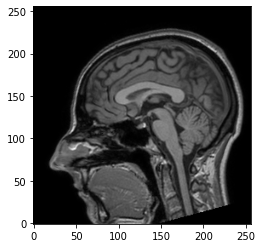

In [65]:
img_rotz_15 = rotation3d(img, 0, 0, 15)
img_arr = sitk.GetArrayFromImage(img_rotz_15)[75,:,:,] # Represents the 0th slice, since numpy swaps the first and third axes default to sitk
plt.imshow(img_arr, origin='lower', cmap='gray', aspect=1)
plt.show()
#plt.imshow(sitk.GetArrayFromImage(resampled_img)[75])

In [46]:
#view(resampled_img, rotate=False)

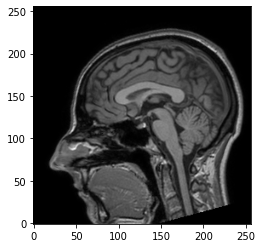

In [47]:
img_arr_br = img_arr * 0.6
plt.imshow(img_arr_br, origin='lower', cmap='gray', aspect=1)
plt.show()

# Brightness

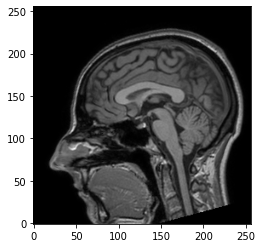

In [77]:
img_gray = img_arr.astype('float32')
plt.imshow(img_gray, origin='lower', cmap='gray', aspect=1)
plt.show()

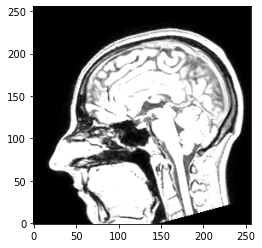

In [78]:
img_gray *=1
img_gray = np.clip(img_gray, 0,255)
plt.imshow(img_gray, origin='lower', cmap='gray', aspect=1)
plt.show()